# Using Machine Learning to Time the Stock Market

**Name:** Chloe Hull <br> 
**Uniqname**: hullcm <br>

**Read Me:** To run this notebook, you will need to download the following files, which are included in my zip file in the data folder: <br>
- Nasdaq Index: NASDAQCOM.csv <br>
- Nasdaq Volatility: VXNCLS.csv <br>
- Interest Rates: DTB3.csv <br>
- Bitcoin Index: CBBTCUSD.csv <br>

Once the files are imported, you will need to ensure that all packages are installed. Most are standard, with the exception of Talos. I have included the pip install statement below (in the "Hyperparameter Tuning for LSTM" section), which you can use to install the package. After that, you will be able to run the code. You can execute the code block by block and it should run without issue. 

The one last item you will need to update is when you use the recover_best_model method from Talos (the code block is titled "#extract best performing model" for easy identification). You need to update the experiment_log name with the file name that is saved to your computer in the "nasdaq" folder. Without this, you will not be able to access the model results from Talos. 

With that, you have all of the information you need to recreate the results from my project. 

In [72]:
#import necessary modules & data
import datetime
from datetime import timedelta
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.layers import LSTM

nasdaq_path = 'data/NASDAQCOM.csv'
nasdaq_volatility_path = 'data/VXNCLS.csv'
tb_int_rate_path = 'data/DTB3.csv'
bitcoin_path = 'data/CBBTCUSD.csv'

nasdaq = pd.read_csv(nasdaq_path)
nasdaq_vol = pd.read_csv(nasdaq_volatility_path)
int_rates = pd.read_csv(tb_int_rate_path)
bitcoin = pd.read_csv(bitcoin_path)

### Data Pre-processing
Because I used FRED data (Federal Reserve Economic Data) which is heavily used across academia and throughout the finance industry, the pre-processing required was relatively minimal. 

In [73]:
nasdaq.rename(columns={'NASDAQCOM': 'Nasdaq_Index'},inplace=True)
nasdaq

,DATE,Nasdaq_Index
0,2001-02-02,2660.50
1,2001-02-05,2643.21
2,2001-02-06,2664.49
3,2001-02-07,2607.82
4,2001-02-08,2562.06
...,...,...
5167,2020-11-24,12036.79
5168,2020-11-25,12094.4
5169,2020-11-26,.
5170,2020-11-27,12205.85


In [74]:
nasdaq_vol.rename(columns={'VXNCLS': 'Nasdaq_Volatility_Index'},inplace=True)
nasdaq_vol

,DATE,Nasdaq_Volatility_Index
0,2001-02-02,54.89
1,2001-02-05,55.85
2,2001-02-06,53.68
3,2001-02-07,54.41
4,2001-02-08,54.66
...,...,...
5168,2020-11-24,25.99
5169,2020-11-25,25.69
5170,2020-11-26,.
5171,2020-11-27,26.12


In [75]:
int_rates.rename(columns={'DTB3': 'three_mo_tbill'},inplace=True)
int_rates

,DATE,three_mo_tbill
0,2001-02-02,4.930
1,2001-02-05,4.960
2,2001-02-06,4.940
3,2001-02-07,4.940
4,2001-02-08,4.950
...,...,...
5167,2020-11-24,0.09
5168,2020-11-25,0.09
5169,2020-11-26,.
5170,2020-11-27,0.09


In [76]:
bitcoin.rename(columns={'CBBTCUSD': 'Bitcoin_Index'},inplace=True)

In [77]:
#merge datasets together
nasdaq_final_data = pd.concat([nasdaq, nasdaq_vol['Nasdaq_Volatility_Index'], int_rates['three_mo_tbill']], axis=1)
nasdaq_final_data = pd.merge(nasdaq_final_data, bitcoin, how='left',on='DATE')

In [78]:
#fill NaN for bitcoin data
nasdaq_final_data = nasdaq_final_data.fillna(0)
nasdaq_final_data = nasdaq_final_data.set_index('DATE')

#adjust Nasdaq Index (predictive value) to be in final column
columns =  ['Nasdaq_Volatility_Index', 'three_mo_tbill', 'Bitcoin_Index', 'Nasdaq_Index']
nasdaq_final_data = nasdaq_final_data[columns]

nasdaq_final_data_train = nasdaq_final_data[:2935]
nasdaq_final_data_test = nasdaq_final_data[2936:]
nasdaq_final_data_test = nasdaq_final_data_test['Nasdaq_Index']

In [79]:
#remove rows with missing data
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Nasdaq_Index != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Nasdaq_Volatility_Index != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.three_mo_tbill != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Bitcoin_Index != '.']
nasdaq_final_data = nasdaq_final_data.iloc[:-1,:]

#missing_rows = nasdaq_final_data[nasdaq_final_data['Nasdaq_Index'].apply(lambda x: x < '0.0')]

nasdaq_final_data

,Nasdaq_Volatility_Index,three_mo_tbill,Bitcoin_Index,Nasdaq_Index
DATE,,,,
2001-02-02,54.89,4.930,0,2660.50
2001-02-05,55.85,4.960,0,2643.21
2001-02-06,53.68,4.940,0,2664.49
2001-02-07,54.41,4.940,0,2607.82
2001-02-08,54.66,4.950,0,2562.06
...,...,...,...,...
2020-11-20,26.81,0.07,18702.87,11854.97
2020-11-23,26.91,0.08,18391.21,11880.63
2020-11-24,26.64,0.09,19185.07,12036.79


In [80]:
#convert into float data types
nasdaq_final_data['Nasdaq_Index'] = pd.to_numeric(nasdaq_final_data['Nasdaq_Index'], downcast="float")
nasdaq_final_data['Nasdaq_Volatility_Index'] = pd.to_numeric(nasdaq_final_data['Nasdaq_Volatility_Index'], downcast="float")
nasdaq_final_data['three_mo_tbill'] = pd.to_numeric(nasdaq_final_data['three_mo_tbill'], downcast="float")
nasdaq_final_data['Bitcoin_Index'] = pd.to_numeric(nasdaq_final_data['Bitcoin_Index'], downcast="float")

In [81]:
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Nasdaq_Index != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Nasdaq_Volatility_Index != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.three_mo_tbill != '.']
nasdaq_final_data = nasdaq_final_data[nasdaq_final_data.Bitcoin_Index != '.']
nasdaq_final_data

,Nasdaq_Volatility_Index,three_mo_tbill,Bitcoin_Index,Nasdaq_Index
DATE,,,,
2001-02-02,54.889999,4.93,0.000000,2660.500000
2001-02-05,55.849998,4.96,0.000000,2643.209961
2001-02-06,53.680000,4.94,0.000000,2664.489990
2001-02-07,54.410000,4.94,0.000000,2607.820068
2001-02-08,54.660000,4.95,0.000000,2562.060059
...,...,...,...,...
2020-11-20,26.809999,0.07,18702.869141,11854.969727
2020-11-23,26.910000,0.08,18391.210938,11880.629883
2020-11-24,26.639999,0.09,19185.070312,12036.790039


In [82]:
#generate X and y data
X = nasdaq_final_data[['three_mo_tbill', 'Bitcoin_Index','Nasdaq_Volatility_Index', ]]
y = nasdaq_final_data['Nasdaq_Index']

In [83]:
#generate train & test (using temporal CV)
tscv = TimeSeriesSplit(max_train_size=None, n_splits=2)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 1588 1589 1590] TEST: [1591 1592 1593 ... 3179 3180 3181]
TRAIN: [   0    1    2 ... 3179 3180 3181] TEST: [3182 3183 3184 ... 4770 4771 4772]


### Evaluate Traditional ML Models (Linear Regression, SVM, Ensembling)
I am first going to evaluate how well traditional ML models perform on this task (predicting the NASDAQ composite index based on previous indicators). Then, I plan to compare these models with time-series models such as LSTM to evaluate what improvement there is (if any).

In [84]:
#import necessary modules 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#### Linear Regression

In [85]:
#train & evaluate Linear Regression model
linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)
score = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print(score, r2)

4026.2703 -383.2930246231431


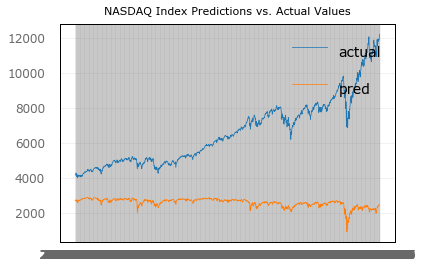

In [86]:
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='pred')
plt.legend()
plt.title('NASDAQ Index Predictions vs. Actual Values')
plt.show()

#### Ridge Regression

In [87]:
ridge = Ridge().fit(X_train, y_train)
y_pred = ridge.predict(X_test)
score = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)
print(score, r2)

4026.2766 -383.2996873993084


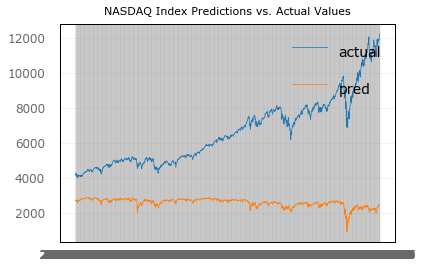

In [88]:
plt.plot(y_test, label='actual')
plt.plot(y_pred, label='pred')
plt.legend()
plt.title('NASDAQ Index Predictions vs. Actual Values')
plt.show()

#### KNN Regression

In [65]:
neighbors = [1,5, 10, 15, 30, 100, 300, 1000]
scores = []
for n in neighbors:
    knn = KNeighborsRegressor(n_neighbors = n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = mean_absolute_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    scores.append((r2, accuracy))
scores

[(-48.398728845657644, 3960.6052),
 (-51.7769770752513, 3917.0286),
 (-50.36249324794327, 3885.919),
 (-48.41591645829024, 3865.7263),
 (-46.18639889671491, 3851.2876),
 (-42.38194791853837, 3845.219),
 (-60.39849574782486, 3810.1572),
 (-247.8476982932552, 4016.372)]

#### XGB Regressor, AdaBoost Regressor & Gradient Boosting Regressor

In [89]:
#Evaluate XGB Regressor, AdaBoost Regressor & Gradient Boosting Regressor

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=1, n_estimators = 100)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_pred, y_test)
print('XGBRegressor Score: ', mae, r2)
    
#Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=50,random_state=1)
gbr.fit(X_train,y_train)
y_preds_gbr = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_preds_gbr)
r2 = r2_score(y_preds_gbr, y_test)
print('GradientBoostingRegressor Score: ', mae, r2)

#Ada Boost Regressor
ada = AdaBoostRegressor(n_estimators=50, random_state=1)
ada.fit(X_train,y_train)
preds_ada = ada.predict(X_test)
mae = mean_absolute_error(y_test, preds_ada)
r2 = r2_score(preds_ada, y_test)
print('AdaBoostRegressor Accuracy: ', mae, r2)

XGBRegressor Score:  4206.5645 -55.703847032815474
GradientBoostingRegressor Score:  4239.229033970917 -58.8693228875271
AdaBoostRegressor Accuracy:  4149.064076139433 -66.99737103160795


#### SVM 

In [66]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
    
#define parameters to search
parameters = {'kernel':['rbf'], 'C':[.1, .5, 1, 5, 10]}
    
#run SVM using gridsearch to find best hyper-parameters
clf = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=True)
clf.fit(X_train_scaled, y_train)
best_kernel = clf.best_params_['kernel']
best_C = clf.best_params_['C']
best_gamma = clf.best_params_['gamma']
test_score = SVC(kernel = best_kernel, gamma = best_gamma,
                 C = best_C).fit(X_train_scaled, y_train).mean_absolute_error(X_test_scaled, y_test)
    
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.5f (+/-%0.03f) for %r"
            % (mean, std * 2, params))
print()
    
print(best_kernel, best_C, best_gamma, test_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.2s finished


ValueError: Unknown label type: 'continuous'

### Evaluate Time-Series Deep Learning Methods (LSTM)


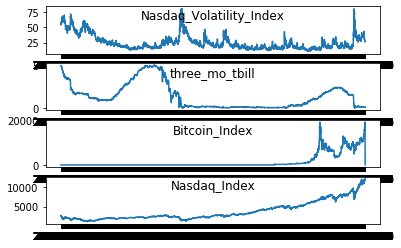

In [59]:
columns = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure()
for column in columns:
    plt.subplot(len(columns), 1, i)
    plt.plot(nasdaq_final_data.iloc[:, column])
    plt.title(nasdaq_final_data.columns[column], y=.6, loc='center')
    i += 1
plt.show()

In [90]:
# convert series to supervised learning
# function taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [91]:
#normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(nasdaq_final_data)

In [92]:
#frame as supervised learning
supervised_learning_nasdaq = series_to_supervised(scaled, 3, 1)
supervised_learning_nasdaq = supervised_learning_nasdaq.drop(columns=['var1(t)', 'var2(t)', 'var3(t)'])
supervised_learning_nasdaq

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
3,0.633869,0.976470,0.000000,0.139508,0.647519,0.982353,0.000000,0.137948,0.616664,0.978431,0.000000,0.139868,0.134755
4,0.647519,0.982353,0.000000,0.137948,0.616664,0.978431,0.000000,0.139868,0.627044,0.978431,0.000000,0.134755,0.130627
5,0.616664,0.978431,0.000000,0.139868,0.627044,0.978431,0.000000,0.134755,0.630599,0.980392,0.000000,0.130627,0.122409
6,0.627044,0.978431,0.000000,0.134755,0.630599,0.980392,0.000000,0.130627,0.647519,0.976470,0.000000,0.122409,0.124095
7,0.630599,0.980392,0.000000,0.130627,0.647519,0.976470,0.000000,0.122409,0.664581,0.976470,0.000000,0.124095,0.118507
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4768,0.242571,0.027451,0.920554,0.972990,0.241718,0.027451,0.927952,0.964172,0.243993,0.023529,0.928036,0.973474,0.968987
4769,0.241718,0.027451,0.927952,0.964172,0.243993,0.023529,0.928036,0.973474,0.234608,0.023529,0.974866,0.968987,0.971302
4770,0.243993,0.023529,0.928036,0.973474,0.234608,0.023529,0.974866,0.968987,0.236030,0.025490,0.958621,0.971302,0.985390
4771,0.234608,0.023529,0.974866,0.968987,0.236030,0.025490,0.958621,0.971302,0.232191,0.027451,1.000000,0.985390,0.990587


In [93]:
# split into train and test sets
nasdaq_values = supervised_learning_nasdaq.values
n_train_data = int(len(supervised_learning_nasdaq)*0.75)
train = nasdaq_values[:n_train_data, :]
test = nasdaq_values[n_train_data:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3577, 1, 12) (3577,) (1193, 1, 12) (1193,)


Epoch 1/10
239/239 - 1s - loss: 0.0191 - val_loss: 0.1489
Epoch 2/10
239/239 - 1s - loss: 0.0163 - val_loss: 0.1300
Epoch 3/10
239/239 - 1s - loss: 0.0134 - val_loss: 0.0954
Epoch 4/10
239/239 - 1s - loss: 0.0141 - val_loss: 0.1021
Epoch 5/10
239/239 - 1s - loss: 0.0126 - val_loss: 0.0663
Epoch 6/10
239/239 - 1s - loss: 0.0117 - val_loss: 0.0806
Epoch 7/10
239/239 - 1s - loss: 0.0113 - val_loss: 0.0681
Epoch 8/10
239/239 - 1s - loss: 0.0116 - val_loss: 0.0582
Epoch 9/10
239/239 - 1s - loss: 0.0110 - val_loss: 0.0531
Epoch 10/10
239/239 - 1s - loss: 0.0116 - val_loss: 0.0416


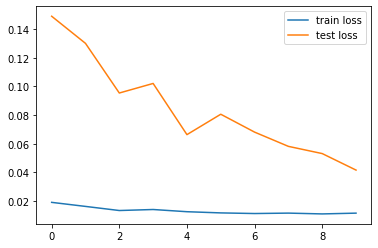

In [18]:
# design network
model = Sequential()
model.add(LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=10, batch_size=15, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [19]:
#evaluate model with epochs = 25, batch_size=15
#generate scaler for inverting the transformation
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame(nasdaq_final_data['Nasdaq_Index']))

# make a prediction
yhat = model.predict(X_test)

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat[inv_yhat < 0] = 0
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#y_test = y_test.reshape((len(y_test), 1))
#inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)

#invert scaling for actuals
inv_y = scaler_y.inverse_transform(pd.DataFrame(y_test))

# calculate RMSE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE for stock predictions: %.3f' % mae)

r2 = r2_score(inv_y, inv_yhat)

print('Test r^2 for county level data: %.3f' % r2)

Test MAE for stock predictions: 461.246
Test r^2 for county level data: 0.861


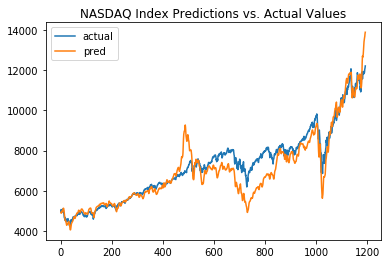

In [25]:
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.title('NASDAQ Index Predictions vs. Actual Values')
plt.show()

In [32]:
#evaluate model with epochs = 8, batch_size=15
#generate scaler for inverting the transformation
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame(nasdaq_final_data['Nasdaq_Index']))

# make a prediction
yhat = model.predict(X_test)

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat[inv_yhat < 0] = 0
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#y_test = y_test.reshape((len(y_test), 1))
#inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)

#invert scaling for actuals
inv_y = scaler_y.inverse_transform(pd.DataFrame(y_test))

# calculate RMSE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE for stock predictions: %.3f' % mae)

r2 = r2_score(inv_y, inv_yhat)

print('Test r^2 for county level data: %.3f' % r2)

Test MAE for stock predictions: 755.398
Test r^2 for county level data: 0.715


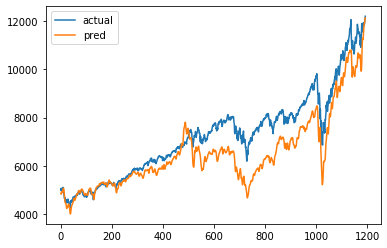

In [33]:
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.show()

### Hyperparameter Tuning for LSTM
#### code for this section adapted from: https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


In [132]:
pip install git+https://github.com/autonomio/talos

  Cloning https://github.com/autonomio/talos to c:\users\chloe\appdata\local\temp\pip-req-build-4u8_jb_8
  Created wheel for talos: filename=talos-1.0-py3-none-any.whl size=54075 sha256=b159fb89ffecdc8e6cfc798e7bcc1c8fa7bfc4a52efd72af9a1f7edda8ff14d0
  Stored in directory: C:\Users\chloe\AppData\Local\Temp\pip-ephem-wheel-cache-7vli_smv\wheels\50\71\1d\ca0ee0e9d7e92eb12f4f00016d9120e6475d8f664a502dc15d
Successfully built talos
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/autonomio/talos 'C:\Users\chloe\AppData\Local\Temp\pip-req-build-4u8_jb_8'


In [94]:
import talos as ta
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import binary_crossentropy, logcosh
from talos.model.normalizers import lr_normalizer

In [95]:
#create function to build model 
def create_model(x_train, y_train, x_test, y_test, params):
    
    #build model
    model = Sequential()
    model.add(LSTM(params['first_neuron'],input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_initializer=params['kernel_initializer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(loss='mae',
              optimizer=params['optimizer'], metrics=['acc'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=(x_test, y_test),
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=2)

    return history, model

In [23]:
#define parameters to test for LSTM
params = {
    'lr': (.2,.5, 5.0, 10.0),
    'first_neuron': [16, 32, 64, 128, 256],
    'hidden_layers': [0, 1, 2],
    'batch_size': [2, 10, 30],
    'epochs': [10],
    'dropout': [0, .2, .5],
    'kernel_initializer': ['uniform','normal'],
    'optimizer': ['adam', 'nadam'],
    'losses': [logcosh, binary_crossentropy],
    'activation': ['relu', 'elu'],
}

In [24]:
#create scan object for talos
t = ta.Scan(
        x=X_train,
        y=y_train,
        model=create_model,
        params=params,
        experiment_name='nasdaq',
        fraction_limit=.01,
        x_val=X_test, 
        y_val=y_test,
)

  0%|          | 0/108 [00:00<?, ?it/s]

Epoch 1/10
358/358 - 1s - loss: 0.0206 - acc: 2.7956e-04 - val_loss: 0.0988 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0594 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0949 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0879 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0782 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0602 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0712 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0455 - val_acc: 0.0000e+00


  1%|          | 1/108 [00:10<19:29, 10.93s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0294 - acc: 2.7956e-04 - val_loss: 0.3954 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.1728 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0633 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0894 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0668 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0651 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0907 - val_acc: 0.0000e+00


  2%|▏         | 2/108 [00:20<18:34, 10.51s/it]

Epoch 1/10
358/358 - 2s - loss: 0.0131 - acc: 2.7956e-04 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0332 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 2s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0571 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 2s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0508 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 2s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0209 - val_acc: 0.0000e+00


  3%|▎         | 3/108 [00:37<21:50, 12.48s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0199 - acc: 2.7956e-04 - val_loss: 0.1246 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0946 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0687 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0607 - val_acc: 0.0000e+00


  4%|▎         | 4/108 [00:47<20:27, 11.81s/it]

Epoch 1/10
1789/1789 - 5s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 5s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 5s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0690 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 5s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0801 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 5s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 5s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 5s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0417 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 5s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0185 - val_acc: 0.0000e+00

  5%|▍         | 5/108 [01:37<39:44, 23.15s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0344 - acc: 2.7956e-04 - val_loss: 0.3739 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.1000 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0045 - acc: 2.7956e-04 - val_loss: 0.0217 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0761 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0690 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0447 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0724 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0596 - val_acc: 0.0000e+00


  6%|▌         | 6/108 [01:44<31:03, 18.27s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0284 - acc: 2.7956e-04 - val_loss: 0.3398 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.1235 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0741 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0328 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0450 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0642 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 1s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0358 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 1s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0371 - val_acc: 0.0000e+00


  6%|▋         | 7/108 [01:56<27:46, 16.50s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0338 - acc: 2.7956e-04 - val_loss: 0.3027 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0136 - acc: 2.7956e-04 - val_loss: 0.2667 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.1166 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0808 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0109 - acc: 2.7956e-04 - val_loss: 0.0130 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.0349 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0657 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0102 - acc: 2.7956e-04 - val_loss: 0.0654 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0105 - acc: 2.7956e-04 - val_loss: 0.1064 - val_acc: 0.0000e+00


  7%|▋         | 8/108 [02:05<23:48, 14.29s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0494 - acc: 2.7956e-04 - val_loss: 0.1317 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0100 - acc: 2.7956e-04 - val_loss: 0.3419 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.1105 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0752 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.1046 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0981 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0971 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0852 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0814 - val_acc: 0.0000e+00


  8%|▊         | 9/108 [02:10<18:52, 11.44s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0388 - acc: 2.7956e-04 - val_loss: 0.2647 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0135 - acc: 2.7956e-04 - val_loss: 0.3095 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.1733 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0100 - acc: 2.7956e-04 - val_loss: 0.0982 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.1002 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0319 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0378 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0179 - val_acc: 0.0000e+00


  9%|▉         | 10/108 [02:16<16:11,  9.91s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0999 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 5s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 4s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0506 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 5s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0080 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 5s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 6s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0472 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 6s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0111 - val_acc: 0.0000e+00

 10%|█         | 11/108 [03:06<35:29, 21.95s/it]

Epoch 1/10
358/358 - 2s - loss: 0.0172 - acc: 2.7956e-04 - val_loss: 0.1683 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0285 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0316 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0449 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0821 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0252 - val_acc: 0.0000e+00


 11%|█         | 12/108 [03:24<32:50, 20.53s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0127 - acc: 2.7956e-04 - val_loss: 0.0385 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0533 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0452 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 5s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0527 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 4s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0086 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 4s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0205 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 4s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 4s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0162 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0348 - val_acc: 0.0000e+00

 12%|█▏        | 13/108 [04:06<42:44, 27.00s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0534 - acc: 2.7956e-04 - val_loss: 0.1185 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.3960 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.1324 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0634 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0769 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0900 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0703 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0706 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0691 - val_acc: 0.0000e+00


 13%|█▎        | 14/108 [04:11<32:04, 20.48s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0300 - acc: 2.7956e-04 - val_loss: 0.3497 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.1728 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0949 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0084 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0071 - acc: 2.7956e-04 - val_loss: 0.0238 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0330 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 1s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0493 - val_acc: 0.0000e+00


 14%|█▍        | 15/108 [04:20<26:19, 16.98s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0218 - acc: 2.7956e-04 - val_loss: 0.1367 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0790 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.1024 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0738 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0737 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0793 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0626 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0690 - val_acc: 0.0000e+00


 15%|█▍        | 16/108 [04:30<22:50, 14.90s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0586 - acc: 2.7956e-04 - val_loss: 0.0813 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0224 - acc: 2.7956e-04 - val_loss: 0.3126 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0159 - acc: 2.7956e-04 - val_loss: 0.3790 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0128 - acc: 2.7956e-04 - val_loss: 0.2888 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.2138 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.1457 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.1316 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0105 - acc: 2.7956e-04 - val_loss: 0.0699 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0104 - acc: 2.7956e-04 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0102 - acc: 2.7956e-04 - val_loss: 0.0138 - val_acc: 0.0000e+00


 16%|█▌        | 17/108 [04:35<18:21, 12.10s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0177 - acc: 2.7956e-04 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0201 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0316 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0808 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0517 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0429 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0455 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0494 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0212 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0128 - val_acc: 0.0000e+00


 17%|█▋        | 18/108 [04:49<18:49, 12.55s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0408 - acc: 2.7956e-04 - val_loss: 0.2169 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0147 - acc: 2.7956e-04 - val_loss: 0.2841 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0123 - acc: 2.7956e-04 - val_loss: 0.1919 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.1083 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0193 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0338 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0627 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0431 - val_acc: 0.0000e+00


 18%|█▊        | 19/108 [04:55<15:44, 10.62s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0216 - acc: 2.7956e-04 - val_loss: 0.2465 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0814 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0106 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0089 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0787 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0388 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0234 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0296 - val_acc: 0.0000e+00


 19%|█▊        | 20/108 [05:07<16:09, 11.01s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0421 - acc: 2.7956e-04 - val_loss: 0.2976 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.3183 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.1510 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0215 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0397 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0721 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0649 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.1115 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0540 - val_acc: 0.0000e+00


 19%|█▉        | 21/108 [05:13<13:54,  9.59s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0698 - acc: 2.7956e-04 - val_loss: 0.1877 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0299 - acc: 2.7956e-04 - val_loss: 0.1679 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0215 - acc: 2.7956e-04 - val_loss: 0.3186 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0171 - acc: 2.7956e-04 - val_loss: 0.3628 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0148 - acc: 2.7956e-04 - val_loss: 0.3512 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0142 - acc: 2.7956e-04 - val_loss: 0.2560 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.1985 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0133 - acc: 2.7956e-04 - val_loss: 0.1546 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0134 - acc: 2.7956e-04 - val_loss: 0.1084 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0135 - acc: 2.7956e-04 - val_loss: 0.0952 - val_acc: 0.0000e+00


 20%|██        | 22/108 [05:18<11:43,  8.18s/it]

Epoch 1/10
358/358 - 3s - loss: 0.0207 - acc: 2.7956e-04 - val_loss: 0.2426 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 3s - loss: 0.0102 - acc: 2.7956e-04 - val_loss: 0.0154 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 3s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 3s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 3s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 3s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0464 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 3s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0608 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 3s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0412 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 3s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0692 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 3s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0588 - val_acc: 0.0000e+00


 21%|██▏       | 23/108 [05:49<21:12, 14.97s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0522 - acc: 2.7956e-04 - val_loss: 0.1526 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.3048 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0784 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0846 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0987 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.1113 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0972 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0858 - val_acc: 0.0000e+00


 22%|██▏       | 24/108 [05:55<17:05, 12.21s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0417 - acc: 2.7956e-04 - val_loss: 0.2316 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0150 - acc: 2.7956e-04 - val_loss: 0.3569 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0119 - acc: 2.7956e-04 - val_loss: 0.3165 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.2125 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0097 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0092 - acc: 2.7956e-04 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0086 - acc: 2.7956e-04 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0552 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.1122 - val_acc: 0.0000e+00


 23%|██▎       | 25/108 [06:01<14:27, 10.45s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0742 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0965 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0493 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 4s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0490 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 4s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0786 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0480 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 4s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0301 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 4s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0323 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0320 - val_acc: 0.0000e+00

 24%|██▍       | 26/108 [06:41<26:26, 19.35s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0562 - acc: 2.7956e-04 - val_loss: 0.1153 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0184 - acc: 2.7956e-04 - val_loss: 0.4038 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0126 - acc: 2.7956e-04 - val_loss: 0.3342 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.2840 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0098 - acc: 2.7956e-04 - val_loss: 0.2073 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.1112 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0442 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0765 - val_acc: 0.0000e+00


 25%|██▌       | 27/108 [06:46<20:22, 15.09s/it]

Epoch 1/10
1789/1789 - 13s - loss: 0.0153 - acc: 2.7956e-04 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 14s - loss: 0.0092 - acc: 2.7956e-04 - val_loss: 0.0314 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 14s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0210 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 15s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 16s - loss: 0.0074 - acc: 2.7956e-04 - val_loss: 0.0515 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 13s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 14s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0450 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 13s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0184 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 13s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 14s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0435 - val_acc: 

 26%|██▌       | 28/108 [09:08<1:10:48, 53.11s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0129 - acc: 2.7956e-04 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0465 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0712 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0751 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0392 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0385 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0526 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0508 - val_acc: 0.0000e+00


 27%|██▋       | 29/108 [09:20<53:32, 40.66s/it]  

Epoch 1/10
120/120 - 1s - loss: 0.0568 - acc: 2.7956e-04 - val_loss: 0.0918 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0130 - acc: 2.7956e-04 - val_loss: 0.3986 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0051 - acc: 2.7956e-04 - val_loss: 0.1533 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0229 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0611 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0764 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.1007 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0973 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0974 - val_acc: 0.0000e+00


 28%|██▊       | 30/108 [09:25<39:02, 30.03s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0184 - acc: 2.7956e-04 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0587 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0882 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0653 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0748 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0618 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0282 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0508 - val_acc: 0.0000e+00


 29%|██▊       | 31/108 [09:37<31:23, 24.46s/it]

Epoch 1/10
120/120 - 2s - loss: 0.0253 - acc: 2.7956e-04 - val_loss: 0.2834 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0820 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0401 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0045 - acc: 2.7956e-04 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0815 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 1s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0538 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 1s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0214 - val_acc: 0.0000e+00


 30%|██▉       | 32/108 [09:51<27:02, 21.35s/it]

Epoch 1/10
1789/1789 - 13s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 13s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 13s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0455 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 13s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0202 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 13s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0401 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 13s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 13s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0287 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 13s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0750 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 13s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0743 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 14s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0265 - val_acc: 

 31%|███       | 33/108 [12:04<1:08:37, 54.90s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0255 - acc: 2.7956e-04 - val_loss: 0.3511 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.1917 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0731 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.1022 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0994 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0830 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0950 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0618 - val_acc: 0.0000e+00


 31%|███▏      | 34/108 [12:14<51:15, 41.56s/it]  

Epoch 1/10
120/120 - 1s - loss: 0.0532 - acc: 2.7956e-04 - val_loss: 0.0949 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0214 - acc: 2.7956e-04 - val_loss: 0.3361 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0150 - acc: 2.7956e-04 - val_loss: 0.3477 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0124 - acc: 2.7956e-04 - val_loss: 0.2811 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.2119 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.1501 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0102 - acc: 2.7956e-04 - val_loss: 0.0838 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.0504 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0104 - acc: 2.7956e-04 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0100 - acc: 2.7956e-04 - val_loss: 0.0131 - val_acc: 0.0000e+00


 32%|███▏      | 35/108 [12:19<37:16, 30.63s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0132 - acc: 2.7956e-04 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0374 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.1010 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0404 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.1018 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0435 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0655 - val_acc: 0.0000e+00

 33%|███▎      | 36/108 [12:54<38:11, 31.82s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0185 - acc: 2.7956e-04 - val_loss: 0.1172 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0298 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0674 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0097 - acc: 2.7956e-04 - val_loss: 0.0906 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0092 - acc: 2.7956e-04 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.0189 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0206 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0236 - val_acc: 0.0000e+00

 34%|███▍      | 37/108 [13:26<37:49, 31.96s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0583 - acc: 2.7956e-04 - val_loss: 0.0870 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0192 - acc: 2.7956e-04 - val_loss: 0.3745 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0129 - acc: 2.7956e-04 - val_loss: 0.3733 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.3059 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.2069 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.1562 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0586 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0074 - acc: 2.7956e-04 - val_loss: 0.0782 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0942 - val_acc: 0.0000e+00


 35%|███▌      | 38/108 [13:31<27:42, 23.75s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0207 - acc: 2.7956e-04 - val_loss: 0.1821 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0726 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0546 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.1074 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0719 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0606 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0348 - val_acc: 0.0000e+00


 36%|███▌      | 39/108 [13:43<23:11, 20.16s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0296 - acc: 2.7956e-04 - val_loss: 0.3210 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0779 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0051 - acc: 2.7956e-04 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0489 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0557 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0740 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0669 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0654 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0527 - val_acc: 0.0000e+00


 37%|███▋      | 40/108 [13:48<17:55, 15.82s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0473 - acc: 2.7956e-04 - val_loss: 0.1203 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0165 - acc: 2.7956e-04 - val_loss: 0.3239 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0125 - acc: 2.7956e-04 - val_loss: 0.2828 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.1614 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0097 - acc: 2.7956e-04 - val_loss: 0.1098 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0190 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0628 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0479 - val_acc: 0.0000e+00


 38%|███▊      | 41/108 [13:53<13:52, 12.43s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0486 - acc: 2.7956e-04 - val_loss: 0.2042 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0131 - acc: 2.7956e-04 - val_loss: 0.4178 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0102 - acc: 2.7956e-04 - val_loss: 0.3131 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.1542 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0573 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0302 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0945 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.1209 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.1070 - val_acc: 0.0000e+00


 39%|███▉      | 42/108 [13:57<11:03, 10.05s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0371 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0395 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0242 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0110 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0120 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00

 40%|███▉      | 43/108 [14:33<19:09, 17.69s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0473 - acc: 2.7956e-04 - val_loss: 0.2970 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.3108 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0690 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0395 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0862 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.1018 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.1046 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.1056 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.1030 - val_acc: 0.0000e+00


 41%|████      | 44/108 [14:37<14:37, 13.72s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0272 - acc: 2.7956e-04 - val_loss: 0.3044 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.1195 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0761 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0177 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0661 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0928 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 1s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 1s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0364 - val_acc: 0.0000e+00


 42%|████▏     | 45/108 [14:45<12:27, 11.87s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0189 - acc: 2.7956e-04 - val_loss: 0.1454 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0108 - acc: 2.7956e-04 - val_loss: 0.0159 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0099 - acc: 2.7956e-04 - val_loss: 0.0127 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.0171 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0501 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0404 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0244 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.0237 - val_acc: 0.0000e+00

 43%|████▎     | 46/108 [15:17<18:27, 17.87s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0299 - acc: 2.7956e-04 - val_loss: 0.3967 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0934 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0210 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0363 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0437 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0513 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0580 - val_acc: 0.0000e+00


 44%|████▎     | 47/108 [15:23<14:33, 14.32s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0547 - acc: 2.7956e-04 - val_loss: 0.0808 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0251 - acc: 2.7956e-04 - val_loss: 0.2512 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0179 - acc: 2.7956e-04 - val_loss: 0.4054 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0152 - acc: 2.7956e-04 - val_loss: 0.3730 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.2818 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0135 - acc: 2.7956e-04 - val_loss: 0.2490 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0135 - acc: 2.7956e-04 - val_loss: 0.1544 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0135 - acc: 2.7956e-04 - val_loss: 0.1162 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0134 - acc: 2.7956e-04 - val_loss: 0.0970 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0132 - acc: 2.7956e-04 - val_loss: 0.0837 - val_acc: 0.0000e+00


 44%|████▍     | 48/108 [15:27<11:14, 11.24s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0156 - acc: 2.7956e-04 - val_loss: 0.1206 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0754 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.1271 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0758 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0692 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0481 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0160 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0176 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0261 - val_acc: 0.0000e+00

 45%|████▌     | 49/108 [15:58<16:48, 17.09s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0242 - acc: 2.7956e-04 - val_loss: 0.2443 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0151 - acc: 2.7956e-04 - val_loss: 0.0930 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0145 - acc: 2.7956e-04 - val_loss: 0.0198 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0145 - acc: 2.7956e-04 - val_loss: 0.0597 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0143 - acc: 2.7956e-04 - val_loss: 0.0792 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.0733 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0145 - acc: 2.7956e-04 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.0415 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.0342 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0142 - acc: 2.7956e-04 - val_loss: 0.0627 - val_acc: 0.0000e+00

 46%|████▋     | 50/108 [16:29<20:37, 21.33s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0365 - acc: 2.7956e-04 - val_loss: 0.3007 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0121 - acc: 2.7956e-04 - val_loss: 0.2902 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.2196 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.1131 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0500 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0281 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0103 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0210 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0408 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0469 - val_acc: 0.0000e+00


 47%|████▋     | 51/108 [16:34<15:45, 16.59s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0219 - acc: 2.7956e-04 - val_loss: 0.1514 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0100 - acc: 2.7956e-04 - val_loss: 0.0591 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0383 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0816 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0808 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0614 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0840 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0520 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0143 - val_acc: 0.0000e+00


 48%|████▊     | 52/108 [16:44<13:29, 14.46s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0205 - acc: 2.7956e-04 - val_loss: 0.2524 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0117 - acc: 2.7956e-04 - val_loss: 0.0320 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0115 - acc: 2.7956e-04 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0878 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0401 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.0463 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0109 - acc: 2.7956e-04 - val_loss: 0.1081 - val_acc: 0.0000e+00

 49%|████▉     | 53/108 [17:15<17:46, 19.40s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0922 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0659 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0491 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0166 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0300 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0181 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0593 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00

 50%|█████     | 54/108 [17:50<21:37, 24.02s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0571 - acc: 2.7956e-04 - val_loss: 0.0977 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0123 - acc: 2.7956e-04 - val_loss: 0.4354 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.1614 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0275 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0476 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0924 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.1119 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0987 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.1052 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0968 - val_acc: 0.0000e+00


 51%|█████     | 55/108 [17:54<16:02, 18.16s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0397 - acc: 2.7956e-04 - val_loss: 0.3227 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.1470 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0275 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0608 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0673 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0701 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0756 - val_acc: 0.0000e+00


 52%|█████▏    | 56/108 [17:59<12:21, 14.26s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0455 - acc: 2.7956e-04 - val_loss: 0.1636 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0161 - acc: 2.7956e-04 - val_loss: 0.3563 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0125 - acc: 2.7956e-04 - val_loss: 0.2510 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.1991 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.1320 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0598 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0355 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0240 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0423 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0539 - val_acc: 0.0000e+00


 53%|█████▎    | 57/108 [18:04<09:44, 11.46s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0296 - acc: 2.7956e-04 - val_loss: 0.2692 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0120 - acc: 2.7956e-04 - val_loss: 0.1708 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0098 - acc: 2.7956e-04 - val_loss: 0.1283 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0206 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0481 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0645 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0644 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0565 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0394 - val_acc: 0.0000e+00


 54%|█████▎    | 58/108 [18:13<08:55, 10.70s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0181 - acc: 2.7956e-04 - val_loss: 0.2533 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0104 - acc: 2.7956e-04 - val_loss: 0.1396 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.0303 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0312 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0318 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0150 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.0550 - val_acc: 0.0000e+00

 55%|█████▍    | 59/108 [18:47<14:31, 17.78s/it]

Epoch 1/10
1789/1789 - 12s - loss: 0.0109 - acc: 2.7956e-04 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 11s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 11s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0558 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 11s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 11s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 12s - loss: 0.0051 - acc: 2.7956e-04 - val_loss: 0.0115 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 11s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0145 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 11s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 12s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0245 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 12s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0187 - val_acc: 

 56%|█████▌    | 60/108 [20:44<38:00, 47.52s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0415 - acc: 2.7956e-04 - val_loss: 0.2816 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0095 - acc: 2.7956e-04 - val_loss: 0.3099 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.1542 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0694 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0617 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0491 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0054 - acc: 2.7956e-04 - val_loss: 0.0583 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0054 - acc: 2.7956e-04 - val_loss: 0.0654 - val_acc: 0.0000e+00


 56%|█████▋    | 61/108 [20:50<27:27, 35.05s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0267 - acc: 2.7956e-04 - val_loss: 0.2958 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0117 - acc: 2.7956e-04 - val_loss: 0.1640 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0615 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0169 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.1086 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0911 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.1089 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0932 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0814 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0874 - val_acc: 0.0000e+00


 57%|█████▋    | 62/108 [21:00<21:07, 27.56s/it]

Epoch 1/10
358/358 - 3s - loss: 0.0174 - acc: 2.7956e-04 - val_loss: 0.1160 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 2s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 2s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0567 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 2s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 3s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0117 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 2s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0440 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 2s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 2s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 2s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0169 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 3s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0493 - val_acc: 0.0000e+00


 58%|█████▊    | 63/108 [21:26<20:19, 27.10s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0133 - acc: 2.7956e-04 - val_loss: 0.0199 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0695 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0423 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0453 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0516 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0273 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0441 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0562 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0351 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0242 - val_acc: 0.0000e+00


 59%|█████▉    | 64/108 [21:36<16:01, 21.85s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0212 - acc: 2.7956e-04 - val_loss: 0.1669 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0124 - acc: 2.7956e-04 - val_loss: 0.0145 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 2s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0702 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0115 - acc: 2.7956e-04 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 2s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.1050 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 2s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0639 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 2s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0514 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0980 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 2s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0525 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0682 - val_acc: 0.0000e+00

 60%|██████    | 65/108 [22:04<16:57, 23.65s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0208 - acc: 2.7956e-04 - val_loss: 0.1600 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0124 - acc: 2.7956e-04 - val_loss: 0.0394 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0210 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0389 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.0862 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.1333 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.0242 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0108 - acc: 2.7956e-04 - val_loss: 0.0559 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0110 - acc: 2.7956e-04 - val_loss: 0.0817 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 2s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.0940 - val_acc: 0.0000e+00

 61%|██████    | 66/108 [22:35<18:13, 26.04s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0161 - acc: 2.7956e-04 - val_loss: 0.1266 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0240 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0618 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0271 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0507 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 4s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0220 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 4s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0177 - val_acc: 0.0000e+00

 62%|██████▏   | 67/108 [23:13<20:14, 29.62s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0186 - acc: 2.7956e-04 - val_loss: 0.1388 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 2s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.1013 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 2s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.1129 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 2s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0962 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 2s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0828 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 2s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.1324 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 2s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.1238 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0668 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 2s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 2s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0149 - val_acc: 0.0000e+00

 63%|██████▎   | 68/108 [23:40<19:07, 28.69s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.0418 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 2s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0466 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0664 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 2s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0855 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 2s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0282 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 2s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0585 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 2s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0456 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 2s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 2s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0145 - val_acc: 0.0000e+00

 64%|██████▍   | 69/108 [24:07<18:17, 28.15s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0744 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.1061 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0622 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0913 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0358 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0496 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0200 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0409 - val_acc: 0.0000e+00

 65%|██████▍   | 70/108 [24:35<17:50, 28.17s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0481 - acc: 2.7956e-04 - val_loss: 0.2152 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0175 - acc: 2.7956e-04 - val_loss: 0.3979 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0129 - acc: 2.7956e-04 - val_loss: 0.3350 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0111 - acc: 2.7956e-04 - val_loss: 0.2290 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.1648 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0092 - acc: 2.7956e-04 - val_loss: 0.1134 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0173 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0875 - val_acc: 0.0000e+00


 66%|██████▌   | 71/108 [24:40<13:01, 21.12s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0210 - acc: 2.7956e-04 - val_loss: 0.2052 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0555 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0748 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0837 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0685 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0899 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0071 - acc: 2.7956e-04 - val_loss: 0.0417 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0431 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0118 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0536 - val_acc: 0.0000e+00


 67%|██████▋   | 72/108 [24:49<10:30, 17.50s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0290 - acc: 2.7956e-04 - val_loss: 0.3985 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0905 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0354 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0239 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0397 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0048 - acc: 2.7956e-04 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0045 - acc: 2.7956e-04 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0045 - acc: 2.7956e-04 - val_loss: 0.0511 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 1s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0537 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 1s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0502 - val_acc: 0.0000e+00


 68%|██████▊   | 73/108 [25:00<09:01, 15.48s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0419 - acc: 2.7956e-04 - val_loss: 0.3114 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.3492 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.1895 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.1196 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0748 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0071 - acc: 2.7956e-04 - val_loss: 0.0172 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0575 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0936 - val_acc: 0.0000e+00


 69%|██████▊   | 74/108 [25:04<06:58, 12.32s/it]

Epoch 1/10
1789/1789 - 13s - loss: 0.0147 - acc: 2.7956e-04 - val_loss: 0.0392 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 14s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.0182 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 12s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0738 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 11s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0181 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 12s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 13s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0211 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 14s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0195 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 13s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0291 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 10s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 11s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0490 - val_acc: 

 69%|██████▉   | 75/108 [27:09<25:20, 46.09s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0445 - acc: 2.7956e-04 - val_loss: 0.1837 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0154 - acc: 2.7956e-04 - val_loss: 0.3629 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0121 - acc: 2.7956e-04 - val_loss: 0.2658 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0106 - acc: 2.7956e-04 - val_loss: 0.1463 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.0850 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0333 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0341 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0178 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0448 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0776 - val_acc: 0.0000e+00


 70%|███████   | 76/108 [27:15<18:06, 33.97s/it]

Epoch 1/10
358/358 - 3s - loss: 0.0205 - acc: 2.7956e-04 - val_loss: 0.1804 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 2s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 2s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 2s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 3s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0370 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 2s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 3s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 3s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0415 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 2s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0365 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 2s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0230 - val_acc: 0.0000e+00


 71%|███████▏  | 77/108 [27:43<16:37, 32.17s/it]

Epoch 1/10
358/358 - 2s - loss: 0.0182 - acc: 2.7956e-04 - val_loss: 0.1608 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0289 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0328 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0058 - acc: 2.7956e-04 - val_loss: 0.0664 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0838 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0051 - acc: 2.7956e-04 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0051 - acc: 2.7956e-04 - val_loss: 0.0416 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0661 - val_acc: 0.0000e+00


 72%|███████▏  | 78/108 [27:59<13:38, 27.28s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0302 - acc: 2.7956e-04 - val_loss: 0.3062 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0117 - acc: 2.7956e-04 - val_loss: 0.2089 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0285 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0524 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0744 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.1175 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.1058 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.1008 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0958 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.1216 - val_acc: 0.0000e+00


 73%|███████▎  | 79/108 [28:08<10:36, 21.93s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0410 - acc: 2.7956e-04 - val_loss: 0.2658 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0137 - acc: 2.7956e-04 - val_loss: 0.3078 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.1792 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0099 - acc: 2.7956e-04 - val_loss: 0.0909 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0505 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0489 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0463 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0577 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0624 - val_acc: 0.0000e+00


 74%|███████▍  | 80/108 [28:14<08:01, 17.20s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0381 - acc: 2.7956e-04 - val_loss: 0.1822 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0172 - acc: 2.7956e-04 - val_loss: 0.3129 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0146 - acc: 2.7956e-04 - val_loss: 0.1926 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0142 - acc: 2.7956e-04 - val_loss: 0.1038 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0141 - acc: 2.7956e-04 - val_loss: 0.0795 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0132 - acc: 2.7956e-04 - val_loss: 0.0398 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0137 - acc: 2.7956e-04 - val_loss: 0.0461 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0138 - acc: 2.7956e-04 - val_loss: 0.0272 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0137 - acc: 2.7956e-04 - val_loss: 0.0425 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0137 - acc: 2.7956e-04 - val_loss: 0.0794 - val_acc: 0.0000e+00


 75%|███████▌  | 81/108 [28:24<06:42, 14.92s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0359 - acc: 2.7956e-04 - val_loss: 0.3385 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0120 - acc: 2.7956e-04 - val_loss: 0.2709 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.1522 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.1214 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.1342 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0815 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.1272 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.1090 - val_acc: 0.0000e+00


 76%|███████▌  | 82/108 [28:32<05:34, 12.86s/it]

Epoch 1/10
358/358 - 2s - loss: 0.0330 - acc: 2.7956e-04 - val_loss: 0.4350 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.3060 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0767 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0242 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0423 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0912 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.1090 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.1098 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0845 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0923 - val_acc: 0.0000e+00


 77%|███████▋  | 83/108 [28:44<05:14, 12.59s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0124 - acc: 2.7956e-04 - val_loss: 0.0592 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0699 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0560 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 4s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0214 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 4s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 4s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00

 78%|███████▊  | 84/108 [29:23<08:08, 20.34s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0256 - acc: 2.7956e-04 - val_loss: 0.1889 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0624 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.1093 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.1019 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.1034 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0931 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.1100 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0762 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0851 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0814 - val_acc: 0.0000e+00


 79%|███████▊  | 85/108 [29:30<06:20, 16.55s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0160 - acc: 2.7956e-04 - val_loss: 0.0534 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0443 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0659 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0768 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0634 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0830 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0820 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0656 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0232 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0472 - val_acc: 0.0000e+00


 80%|███████▉  | 86/108 [29:39<05:14, 14.29s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0355 - acc: 2.7956e-04 - val_loss: 0.3426 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0854 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0367 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0514 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0610 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0576 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0614 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0723 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0663 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0030 - acc: 2.7956e-04 - val_loss: 0.0442 - val_acc: 0.0000e+00


 81%|████████  | 87/108 [29:45<04:04, 11.62s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0180 - acc: 2.7956e-04 - val_loss: 0.0804 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0044 - acc: 2.7956e-04 - val_loss: 0.0798 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0908 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0825 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0622 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0698 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0486 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0407 - val_acc: 0.0000e+00


 81%|████████▏ | 88/108 [29:55<03:43, 11.16s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0325 - acc: 2.7956e-04 - val_loss: 0.3983 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.1611 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0069 - acc: 2.7956e-04 - val_loss: 0.0362 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0469 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0684 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0381 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0782 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0647 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0052 - acc: 2.7956e-04 - val_loss: 0.0614 - val_acc: 0.0000e+00


 82%|████████▏ | 89/108 [30:01<03:02,  9.60s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0181 - acc: 2.7956e-04 - val_loss: 0.1783 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0090 - acc: 2.7956e-04 - val_loss: 0.0268 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.1401 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.1154 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.1428 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0819 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0529 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0635 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 2s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0883 - val_acc: 0.0000e+00

 83%|████████▎ | 90/108 [30:38<05:22, 17.89s/it]

Epoch 1/10
358/358 - 2s - loss: 0.0136 - acc: 2.7956e-04 - val_loss: 0.0716 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 2s - loss: 0.0053 - acc: 2.7956e-04 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 2s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0402 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 2s - loss: 0.0043 - acc: 2.7956e-04 - val_loss: 0.0536 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 2s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0308 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 2s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 2s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0705 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 2s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0293 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 2s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0324 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 2s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0467 - val_acc: 0.0000e+00


 84%|████████▍ | 91/108 [31:02<05:37, 19.86s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0222 - acc: 2.7956e-04 - val_loss: 0.1858 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0127 - acc: 2.7956e-04 - val_loss: 0.0851 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0117 - acc: 2.7956e-04 - val_loss: 0.0197 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0115 - acc: 2.7956e-04 - val_loss: 0.0395 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0690 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0116 - acc: 2.7956e-04 - val_loss: 0.0224 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 2s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.0246 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 2s - loss: 0.0113 - acc: 2.7956e-04 - val_loss: 0.0430 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.0697 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0107 - acc: 2.7956e-04 - val_loss: 0.0290 - val_acc: 0.0000e+00

 85%|████████▌ | 92/108 [31:31<05:57, 22.35s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0272 - acc: 2.7956e-04 - val_loss: 0.3981 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.1387 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0507 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0654 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0693 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.1174 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.1067 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.1242 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.1417 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0061 - acc: 2.7956e-04 - val_loss: 0.0975 - val_acc: 0.0000e+00


 86%|████████▌ | 93/108 [31:40<04:36, 18.44s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0189 - acc: 2.7956e-04 - val_loss: 0.1189 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0104 - acc: 2.7956e-04 - val_loss: 0.0373 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0364 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.0294 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0091 - acc: 2.7956e-04 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0093 - acc: 2.7956e-04 - val_loss: 0.0566 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0205 - val_acc: 0.0000e+00

 87%|████████▋ | 94/108 [32:16<05:31, 23.66s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0275 - acc: 2.7956e-04 - val_loss: 0.3162 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 1s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0483 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0284 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0399 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 1s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0031 - acc: 2.7956e-04 - val_loss: 0.0422 - val_acc: 0.0000e+00


 88%|████████▊ | 95/108 [32:23<04:05, 18.87s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0243 - acc: 2.7956e-04 - val_loss: 0.2512 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0096 - acc: 2.7956e-04 - val_loss: 0.0666 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0151 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0070 - acc: 2.7956e-04 - val_loss: 0.0324 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0067 - acc: 2.7956e-04 - val_loss: 0.0646 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0602 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0884 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0984 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0871 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0495 - val_acc: 0.0000e+00


 89%|████████▉ | 96/108 [32:32<03:08, 15.69s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0453 - acc: 2.7956e-04 - val_loss: 0.1751 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0166 - acc: 2.7956e-04 - val_loss: 0.2927 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0123 - acc: 2.7956e-04 - val_loss: 0.2718 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0109 - acc: 2.7956e-04 - val_loss: 0.1843 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0098 - acc: 2.7956e-04 - val_loss: 0.1140 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0085 - acc: 2.7956e-04 - val_loss: 0.0328 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0140 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0081 - acc: 2.7956e-04 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0345 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0412 - val_acc: 0.0000e+00


 90%|████████▉ | 97/108 [32:36<02:15, 12.31s/it]

Epoch 1/10
1789/1789 - 3s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.0673 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0874 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0468 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0492 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0530 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0499 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0337 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0662 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0580 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0107 - val_acc: 0.0000e+00

 91%|█████████ | 98/108 [33:07<02:59, 17.92s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0532 - acc: 2.7956e-04 - val_loss: 0.0894 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0216 - acc: 2.7956e-04 - val_loss: 0.3186 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0167 - acc: 2.7956e-04 - val_loss: 0.4327 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0134 - acc: 2.7956e-04 - val_loss: 0.3385 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0120 - acc: 2.7956e-04 - val_loss: 0.2875 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.1618 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0109 - acc: 2.7956e-04 - val_loss: 0.1426 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0105 - acc: 2.7956e-04 - val_loss: 0.0923 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0103 - acc: 2.7956e-04 - val_loss: 0.0574 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.0132 - val_acc: 0.0000e+00


 92%|█████████▏| 99/108 [33:12<02:06, 14.05s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0170 - acc: 2.7956e-04 - val_loss: 0.1665 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 4s - loss: 0.0100 - acc: 2.7956e-04 - val_loss: 0.0522 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 4s - loss: 0.0088 - acc: 2.7956e-04 - val_loss: 0.0152 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0181 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0519 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 4s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0386 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.0217 - val_acc: 0.0000e+00

 93%|█████████▎| 100/108 [33:49<02:48, 21.01s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0083 - acc: 2.7956e-04 - val_loss: 0.0753 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0049 - acc: 2.7956e-04 - val_loss: 0.0157 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0045 - acc: 2.7956e-04 - val_loss: 0.0489 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 3s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0403 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 4s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0165 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0582 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 4s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0640 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0040 - acc: 2.7956e-04 - val_loss: 0.0270 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 3s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 3s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0314 - val_acc: 0.0000e+00

 94%|█████████▎| 101/108 [34:26<03:00, 25.81s/it]

Epoch 1/10
358/358 - 3s - loss: 0.0157 - acc: 2.7956e-04 - val_loss: 0.0693 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 3s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0170 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 2s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 2s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.0769 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 2s - loss: 0.0056 - acc: 2.7956e-04 - val_loss: 0.0730 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 2s - loss: 0.0054 - acc: 2.7956e-04 - val_loss: 0.0327 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 2s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0366 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 2s - loss: 0.0050 - acc: 2.7956e-04 - val_loss: 0.0599 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 2s - loss: 0.0047 - acc: 2.7956e-04 - val_loss: 0.0227 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 2s - loss: 0.0046 - acc: 2.7956e-04 - val_loss: 0.0523 - val_acc: 0.0000e+00


 94%|█████████▍| 102/108 [34:53<02:35, 25.98s/it]

Epoch 1/10
120/120 - 1s - loss: 0.0396 - acc: 2.7956e-04 - val_loss: 0.2552 - val_acc: 0.0000e+00
Epoch 2/10
120/120 - 0s - loss: 0.0140 - acc: 2.7956e-04 - val_loss: 0.3030 - val_acc: 0.0000e+00
Epoch 3/10
120/120 - 0s - loss: 0.0112 - acc: 2.7956e-04 - val_loss: 0.1932 - val_acc: 0.0000e+00
Epoch 4/10
120/120 - 0s - loss: 0.0092 - acc: 2.7956e-04 - val_loss: 0.1510 - val_acc: 0.0000e+00
Epoch 5/10
120/120 - 0s - loss: 0.0089 - acc: 2.7956e-04 - val_loss: 0.0660 - val_acc: 0.0000e+00
Epoch 6/10
120/120 - 0s - loss: 0.0079 - acc: 2.7956e-04 - val_loss: 0.0285 - val_acc: 0.0000e+00
Epoch 7/10
120/120 - 0s - loss: 0.0074 - acc: 2.7956e-04 - val_loss: 0.0288 - val_acc: 0.0000e+00
Epoch 8/10
120/120 - 0s - loss: 0.0071 - acc: 2.7956e-04 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 9/10
120/120 - 0s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0707 - val_acc: 0.0000e+00
Epoch 10/10
120/120 - 0s - loss: 0.0068 - acc: 2.7956e-04 - val_loss: 0.0582 - val_acc: 0.0000e+00


 95%|█████████▌| 103/108 [34:58<01:38, 19.74s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0254 - acc: 2.7956e-04 - val_loss: 0.2875 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0094 - acc: 2.7956e-04 - val_loss: 0.1433 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0353 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0072 - acc: 2.7956e-04 - val_loss: 0.0613 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0066 - acc: 2.7956e-04 - val_loss: 0.0698 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0064 - acc: 2.7956e-04 - val_loss: 0.0733 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0686 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0062 - acc: 2.7956e-04 - val_loss: 0.0881 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0063 - acc: 2.7956e-04 - val_loss: 0.0794 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0593 - val_acc: 0.0000e+00


 96%|█████████▋| 104/108 [35:07<01:05, 16.50s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0303 - acc: 2.7956e-04 - val_loss: 0.3767 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0114 - acc: 2.7956e-04 - val_loss: 0.2601 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0087 - acc: 2.7956e-04 - val_loss: 0.1407 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0084 - acc: 2.7956e-04 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0805 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.1021 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0078 - acc: 2.7956e-04 - val_loss: 0.0761 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.1262 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.1424 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0076 - acc: 2.7956e-04 - val_loss: 0.1369 - val_acc: 0.0000e+00


 97%|█████████▋| 105/108 [35:15<00:41, 13.90s/it]

Epoch 1/10
1789/1789 - 4s - loss: 0.0117 - acc: 2.7956e-04 - val_loss: 0.0217 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 3s - loss: 0.0074 - acc: 2.7956e-04 - val_loss: 0.0503 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 3s - loss: 0.0065 - acc: 2.7956e-04 - val_loss: 0.0948 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 4s - loss: 0.0060 - acc: 2.7956e-04 - val_loss: 0.0579 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 3s - loss: 0.0059 - acc: 2.7956e-04 - val_loss: 0.1000 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 3s - loss: 0.0057 - acc: 2.7956e-04 - val_loss: 0.0755 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 3s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 3s - loss: 0.0054 - acc: 2.7956e-04 - val_loss: 0.0540 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 4s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0322 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 4s - loss: 0.0055 - acc: 2.7956e-04 - val_loss: 0.0234 - val_acc: 0.0000e+00

 98%|█████████▊| 106/108 [35:52<00:41, 20.99s/it]

Epoch 1/10
358/358 - 1s - loss: 0.0210 - acc: 2.7956e-04 - val_loss: 0.1395 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0041 - acc: 2.7956e-04 - val_loss: 0.0721 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0038 - acc: 2.7956e-04 - val_loss: 0.0998 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0036 - acc: 2.7956e-04 - val_loss: 0.0982 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0924 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0685 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0568 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0667 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0434 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0523 - val_acc: 0.0000e+00


 99%|█████████▉| 107/108 [36:01<00:17, 17.36s/it]

Epoch 1/10
1789/1789 - 8s - loss: 0.0153 - acc: 2.7956e-04 - val_loss: 0.0976 - val_acc: 0.0000e+00
Epoch 2/10
1789/1789 - 7s - loss: 0.0101 - acc: 2.7956e-04 - val_loss: 0.0386 - val_acc: 0.0000e+00
Epoch 3/10
1789/1789 - 7s - loss: 0.0082 - acc: 2.7956e-04 - val_loss: 0.0417 - val_acc: 0.0000e+00
Epoch 4/10
1789/1789 - 6s - loss: 0.0080 - acc: 2.7956e-04 - val_loss: 0.0456 - val_acc: 0.0000e+00
Epoch 5/10
1789/1789 - 7s - loss: 0.0077 - acc: 2.7956e-04 - val_loss: 0.0604 - val_acc: 0.0000e+00
Epoch 6/10
1789/1789 - 7s - loss: 0.0075 - acc: 2.7956e-04 - val_loss: 0.0303 - val_acc: 0.0000e+00
Epoch 7/10
1789/1789 - 6s - loss: 0.0074 - acc: 2.7956e-04 - val_loss: 0.0168 - val_acc: 0.0000e+00
Epoch 8/10
1789/1789 - 7s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0344 - val_acc: 0.0000e+00
Epoch 9/10
1789/1789 - 6s - loss: 0.0073 - acc: 2.7956e-04 - val_loss: 0.0510 - val_acc: 0.0000e+00
Epoch 10/10
1789/1789 - 7s - loss: 0.0071 - acc: 2.7956e-04 - val_loss: 0.0487 - val_acc: 0.0000e+00

100%|██████████| 108/108 [37:12<00:00, 20.67s/it]


In [27]:
#extract best performing model 
from talos.utils.recover_best_model import recover_best_model

results, models = recover_best_model(x_train=X_train,
                                     y_train=y_train.reshape(-1,1),
                                     x_val=X_test,
                                     y_val=y_test.reshape(-1,1),
                                     experiment_log='nasdaq/120720104213.csv',
                                     input_model=create_model,
                                     n_models=5,
                                     task='continuous')

Epoch 1/10
358/358 - 1s - loss: 0.0225 - acc: 2.7956e-04 - val_loss: 0.1450 - val_acc: 0.0000e+00
Epoch 2/10
358/358 - 1s - loss: 0.0042 - acc: 2.7956e-04 - val_loss: 0.0738 - val_acc: 0.0000e+00
Epoch 3/10
358/358 - 1s - loss: 0.0039 - acc: 2.7956e-04 - val_loss: 0.0751 - val_acc: 0.0000e+00
Epoch 4/10
358/358 - 1s - loss: 0.0037 - acc: 2.7956e-04 - val_loss: 0.0966 - val_acc: 0.0000e+00
Epoch 5/10
358/358 - 1s - loss: 0.0035 - acc: 2.7956e-04 - val_loss: 0.0475 - val_acc: 0.0000e+00
Epoch 6/10
358/358 - 1s - loss: 0.0034 - acc: 2.7956e-04 - val_loss: 0.0771 - val_acc: 0.0000e+00
Epoch 7/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0730 - val_acc: 0.0000e+00
Epoch 8/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 9/10
358/358 - 1s - loss: 0.0033 - acc: 2.7956e-04 - val_loss: 0.0652 - val_acc: 0.0000e+00
Epoch 10/10
358/358 - 1s - loss: 0.0032 - acc: 2.7956e-04 - val_loss: 0.0667 - val_acc: 0.0000e+00
Epoch 1/10
1789/178

In [35]:
#review best model results
results.sort_values(by=['crossval_mean_f1score'])

,round_epochs,loss,acc,val_loss,val_acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,kernel_initializer,losses,lr,optimizer,crossval_mean_f1score
77,10,0.004715,0.00028,0.066075,0.0,elu,10,0.2,10,128,2,normal,<function log_cosh at 0x000002043F933948>,0.26,nadam,0.008532
79,10,0.007315,0.00028,0.062374,0.0,relu,30,0.5,10,128,2,normal,<function binary_crossentropy at 0x000002043F9...,0.26,nadam,0.031581
68,10,0.003628,0.00028,0.014481,0.0,elu,2,0.0,10,32,1,normal,<function binary_crossentropy at 0x000002043F9...,0.44,adam,0.040356
0,10,0.003147,0.00028,0.045520,0.0,elu,10,0.0,10,32,1,normal,<function binary_crossentropy at 0x000002043F9...,0.26,nadam,0.066851
78,10,0.007504,0.00028,0.121612,0.0,relu,10,0.2,10,16,2,normal,<function binary_crossentropy at 0x000002043F9...,0.38,adam,0.072265


In [40]:
##evaluate performance of best LSTM
#generate scaler for inverting the transformation
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame(nasdaq_final_data['Nasdaq_Index']))

# make a prediction
yhat = models[4].predict(X_test)

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat)
inv_yhat[inv_yhat < 0] = 0
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
#y_test = y_test.reshape((len(y_test), 1))
#inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)

#invert scaling for actuals
inv_y = scaler_y.inverse_transform(pd.DataFrame(y_test))

# calculate RMSE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE for stock predictions: %.3f' % mae)

r2 = r2_score(inv_y, inv_yhat)

print('Test r^2 for county level data: %.3f' % r2)

Test MAE for stock predictions: 94.493
Test r^2 for county level data: 0.994


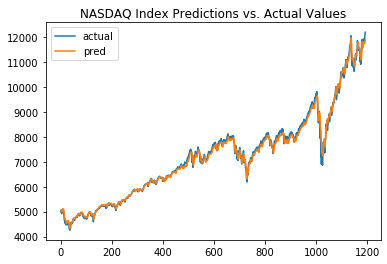

In [41]:
plt.plot(inv_y, label='actual')
plt.plot(inv_yhat, label='pred')
plt.legend()
plt.title('NASDAQ Index Predictions vs. Actual Values')
plt.show()

In [46]:
# accessing the saved models
t.saved_models

# accessing the saved weights for models
t.saved_weights

[[array([[-0.02109528,  0.05291897, -0.04870868, ...,  0.10672653,
           0.03748033,  0.01049463],
         [-0.02306332, -0.02189229, -0.01820854, ...,  0.0609428 ,
          -0.00101182,  0.1057182 ],
         [-0.05961548, -0.01147122, -0.10232615, ..., -0.05975042,
           0.01647909,  0.01147763],
         ...,
         [-0.02251727,  0.01487295, -0.10086464, ..., -0.04846486,
           0.06079561, -0.09416804],
         [ 0.05301167,  0.06765147, -0.1554971 , ..., -0.00774098,
          -0.05173033, -0.07571969],
         [ 0.0671289 ,  0.11422118, -0.05133395, ...,  0.07579546,
           0.17572725,  0.03822399]], dtype=float32),
  array([[-0.02335   ,  0.13298811, -0.07782915, ...,  0.03704933,
          -0.13025877,  0.06778139],
         [-0.08806112,  0.05547775, -0.01176089, ..., -0.12065764,
          -0.13691145,  0.04900286],
         [ 0.01945593, -0.16464102, -0.0150268 , ..., -0.00627175,
          -0.10606682, -0.02049911],
         ...,
         [-0.100352

In [47]:
# use Scan object as input
analyze_object = ta.Analyze(t)
analyze_object.data

,start,end,duration,round_epochs,loss,acc,val_loss,val_acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,kernel_initializer,losses,lr,optimizer
0,12/07/20-104213,12/07/20-104224,10.824393,10,0.003147,0.00028,0.045520,0.0,elu,10,0.0,10,32,1,normal,<function binary_crossentropy at 0x000002043F9...,0.26,nadam
1,12/07/20-104224,12/07/20-104233,9.356156,10,0.006265,0.00028,0.090695,0.0,relu,10,0.2,10,32,1,normal,<function binary_crossentropy at 0x000002043F9...,0.26,adam
2,12/07/20-104233,12/07/20-104250,16.884283,10,0.003541,0.00028,0.020949,0.0,relu,10,0.0,10,256,2,normal,<function binary_crossentropy at 0x000002043F9...,0.20,adam
3,12/07/20-104251,12/07/20-104301,10.075358,10,0.003176,0.00028,0.060749,0.0,elu,10,0.0,10,32,0,normal,<function log_cosh at 0x000002043F933948>,0.38,nadam
4,12/07/20-104301,12/07/20-104350,49.476014,10,0.003436,0.00028,0.018519,0.0,relu,2,0.0,10,128,2,normal,<function log_cosh at 0x000002043F933948>,0.20,nadam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,12/07/20-111711,12/07/20-111720,8.769579,10,0.006488,0.00028,0.059264,0.0,elu,10,0.2,10,32,1,uniform,<function log_cosh at 0x000002043F933948>,0.20,adam
104,12/07/20-111720,12/07/20-111728,7.709546,10,0.007573,0.00028,0.136869,0.0,relu,10,0.2,10,16,2,uniform,<function binary_crossentropy at 0x000002043F9...,0.20,adam
105,12/07/20-111728,12/07/20-111806,37.350664,10,0.005453,0.00028,0.023389,0.0,elu,2,0.2,10,128,1,uniform,<function binary_crossentropy at 0x000002043F9...,0.32,adam
106,12/07/20-111806,12/07/20-111814,8.746142,10,0.003199,0.00028,0.052282,0.0,relu,10,0.0,10,32,1,uniform,<function binary_crossentropy at 0x000002043F9...,0.20,nadam


In [48]:
# get the number of rounds in the Scan
analyze_object.rounds()

# get the highest result for any metric
print('Lowest validation loss:', analyze_object.low('val_loss'))

# get the round with the best result
#analyze_object.rounds2high('val_loss')

# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

Lowest validation loss: 0.010725720785558224


array([['nadam', 0.0, 32, '12/07/20-104213', 10, 10.824393272399902, 10,
        'elu', <function binary_crossentropy at 0x000002043F933CA8>,
        0.26, 10, '12/07/20-104224', 'normal', 1, 0],
       ['adam', 0.0, 32, '12/07/20-110553', 10, 26.75195837020874, 2,
        'elu', <function binary_crossentropy at 0x000002043F933CA8>,
        0.44, 10, '12/07/20-110620', 'normal', 1, 1],
       ['nadam', 0.5, 128, '12/07/20-111022', 10, 5.983545303344727, 30,
        'relu', <function binary_crossentropy at 0x000002043F933CA8>,
        0.26, 10, '12/07/20-111028', 'normal', 2, 2],
       ['adam', 0.2, 16, '12/07/20-111012', 10, 9.314335584640503, 10,
        'relu', <function binary_crossentropy at 0x000002043F933CA8>,
        0.38, 10, '12/07/20-111022', 'normal', 2, 3],
       ['nadam', 0.2, 128, '12/07/20-110956', 10, 15.697137832641602, 10,
        'elu', <function log_cosh at 0x000002043F933948>, 0.26, 10,
        '12/07/20-111012', 'normal', 2, 4],
       ['nadam', 0.5, 256, '12/07

In [49]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

duration        -0.316454
round_epochs          NaN
val_acc               NaN
batch_size       0.288626
dropout          0.013157
epochs                NaN
first_neuron    -0.414880
hidden_layers    0.012188
lr               0.011078
Name: val_loss, dtype: float64

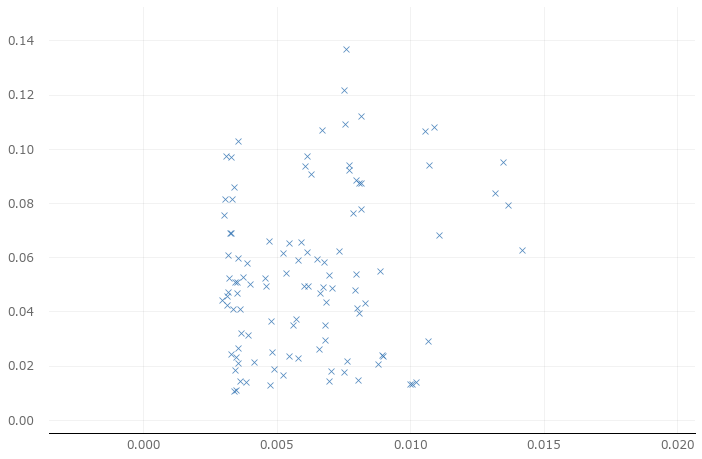

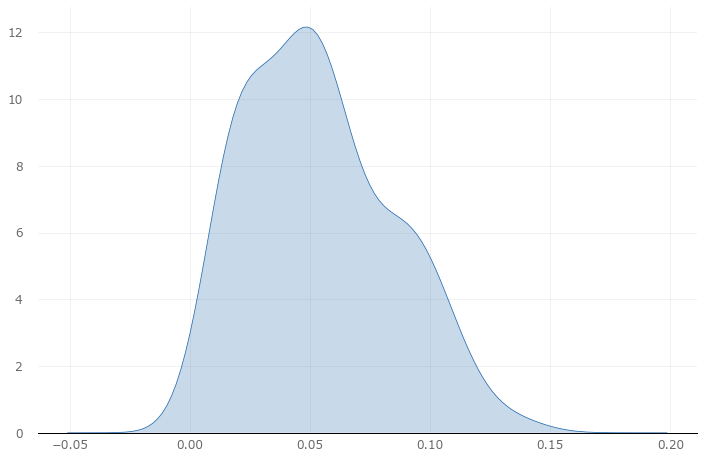

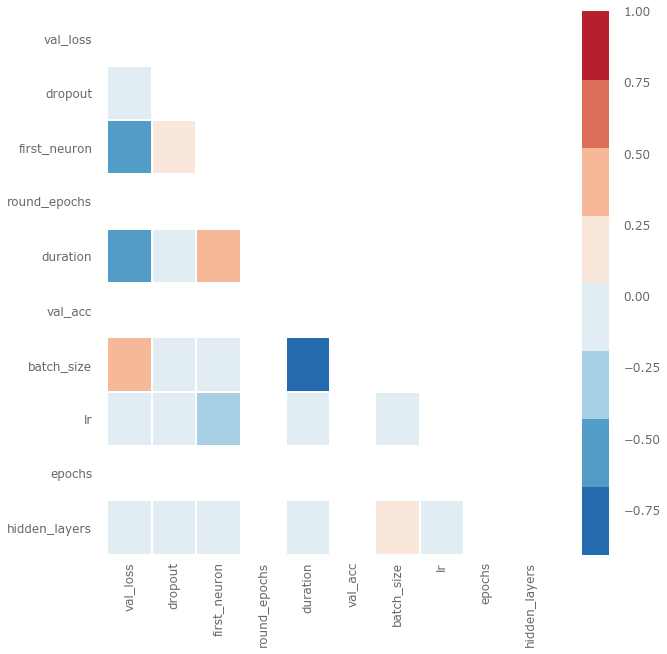

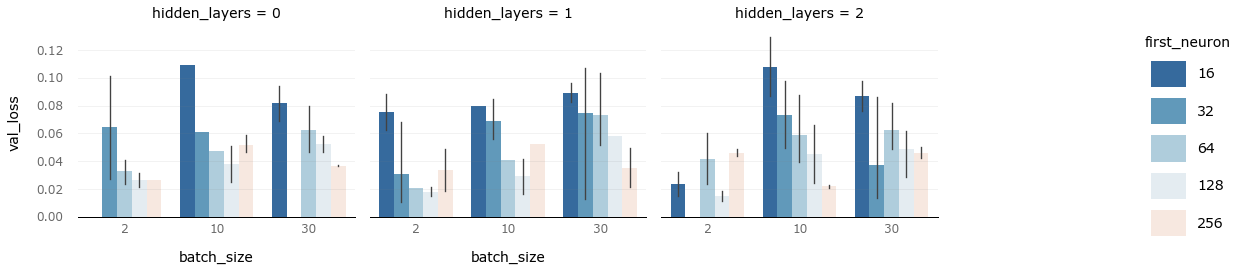

In [71]:
# a regression plot for two dimensions 
analyze_object.plot_regs('loss', 'val_loss')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_loss')

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

analyze_object.plot_bars('batch_size', 'val_loss', 'first_neuron', 'hidden_layers')

In [53]:
evaluate_object = ta.Evaluate(t)
evaluate_object.evaluate(X_train, y_train.reshape(-1,1), folds=10, metric='val_acc', task='continuous')

[0.0030065791,
 0.002761931,
 0.0028065506,
 0.0028709713,
 0.0027712015,
 0.0027046707,
 0.0026439119,
 0.0029803745,
 0.0026502938,
 0.0028077394]